# INTRODUCTION

A mega-online shopping mall provides different baby brands to customers. In order to optimize online advertisements throughout websites, they want to predict the view-to-click probability given the information below.

The data consists of:

Action: the “interaction” that users completed when online ad was exposed. There are two types of actions in this dataset, View (a.k.a Impression) or Click. (Reference: https://en.wikipedia.org/wiki/Impression_(online_media))
ID: unique user IDs
Action Time: the time when action (View/Click) happened, in microseconds format
Website: the website where the ad was published
Banner Size: the banner size of ad
Brand: the brand name that the ad was promoting
Colour: the colour of product showcased in the ad
Interaction Time: user’s interaction time with each ad (sec)

Goal: Predict the Likelihood of Click

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
!pip install SQLAlchemy
!pip install pymysql
from sqlalchemy import create_engine
import pymysql
import configparser
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

In [3]:
## read data from ctrdata.csv
Origin = pd.read_csv('/content/drive/My Drive/website project/test3_data.csv')
Origin = Origin.set_index('Unnamed: 0')
Origin.head()

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
Unnamed: 0,,,,,,,,
1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,View,Facebook,300x600,Carter's,Pink,0.171601
2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,View,Facebook,300x250,Burberry,Red,4.303945
3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,View,Facebook,728x90,Disney,Yellow,0.868106
4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,View,Facebook,320x50,Carter's,Yellow,0.802647
5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,View,instagram.com,300x250,Gap,Gold,0.627148


# EDA & FEATURE ENGINEERING

In [4]:
## Convert outcomes to 1 or 0 
Origin['Action'] = Origin['Action'].replace({'View':0,'Click':1})
Origin.head()

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
Unnamed: 0,,,,,,,,
1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,0,Facebook,300x600,Carter's,Pink,0.171601
2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,0,Facebook,300x250,Burberry,Red,4.303945
3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,0,Facebook,728x90,Disney,Yellow,0.868106
4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,0,Facebook,320x50,Carter's,Yellow,0.802647
5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,0,instagram.com,300x250,Gap,Gold,0.627148


In [5]:
## Detemine output, split testdata
from sklearn.model_selection import train_test_split
X = Origin.drop(columns=['Action'])
y = Origin['Action']

adX_train, adX_test, ady_train, ady_test = train_test_split(X, y, test_size=0.25)
adX_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750000 entries, 326056 to 988700
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               750000 non-null  object 
 1   ActionTime       750000 non-null  int64  
 2   Website          750000 non-null  object 
 3   BannerSize       750000 non-null  object 
 4   Brand            750000 non-null  object 
 5   colour           750000 non-null  object 
 6   InteractionTime  749994 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 45.8+ MB


In [6]:
## Filling missing values
ITmean = adX_train['InteractionTime'].mean() 
adX_train['InteractionTime'] = adX_train['InteractionTime'].fillna(ITmean)

In [13]:
## Feature ID examination 
adX_train['ID'].value_counts().describe()

count    190416.000000
mean          3.938745
std          12.360767
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max        1683.000000
Name: ID, dtype: float64

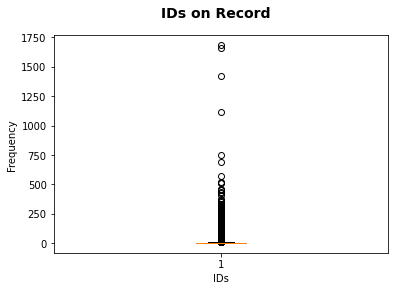

In [12]:
## Feature ID examination 
data = adX_train['ID'].value_counts()
# Boxplot the count of IDs
fig = plt.figure()
fig.suptitle('IDs on Record', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(data)

ax.set_xlabel('IDs')
ax.set_ylabel('Frequency')

plt.show(); 
## Base on the ID analysis, the times of ad viewing by different users range from 1 to almost 1750 times

In [19]:
## Feature ID Engineering: convert ID to degree of interactions based on the number of ID on record
data = adX_train['ID'].value_counts()
## Assign ranges to the frequency of ID

Number_IDs = [0, 1.5, 3.5, 5.5, 10, 1750]

## Determine the degree of website interaction; e.g. if a user's ID appears 1000 times a day, she is determined
## as a highly active online user

degree = ['Occationally Use', 'Normal', 'Frequent', 'Active', 'Highly Active']
adX_train = adX_train.set_index('ID')
adX_train['InteractiveDegree'] = pd.cut(data, bins=Number_IDs, labels=degree)
adX_train = adX_train.reset_index()
adX_train['InteractiveDegree']

0                   Normal
1            Highly Active
2            Highly Active
3         Occationally Use
4            Highly Active
                ...       
749995    Occationally Use
749996              Normal
749997              Active
749998    Occationally Use
749999            Frequent
Name: InteractiveDegree, Length: 750000, dtype: category
Categories (5, object): ['Occationally Use' < 'Normal' < 'Frequent' < 'Active' < 'Highly Active']

In [21]:
## Datetime exploration
adX_train['ActionTime']
## the feature need to be converted to datime format

0         1506301185051263
1         1505163746071675
2         1501919745902429
3         1502381239943911
4         1501338113506252
                ...       
749995    1506228369044639
749996    1501168925182189
749997    1501607620864332
749998    1508273391314275
749999    1504297389756462
Name: ActionTime, Length: 750000, dtype: int64

In [ ]:
## Datetime Engineering
## Convert ActionTime to regular timestamp
adX_train['ActionTime']=pd.to_datetime(adX_train['ActionTime'].astype('float64')/10**6, unit='s')

In [26]:


## Classify the ActionTime timestamp to different periods of a day
hr = pd.to_datetime(adX_train ['ActionTime']).dt.hour
time = [-1, 2.1, 6.1, 9.1, 11.1, 19.1, 24]
## If the view action happen at 2:00 am, it is classified as late_night
time_name = ['late_night', 'early_morning', 'morning', 'noon', 'afternoon', 'evening']
adX_train['Daysection'] = pd.cut(hr, bins=time, labels=time_name)


## Classify the ActionTime timestamp to either a weekday or weekend
def wd(a):
    if a==5 or a==6:
        b='weekend'
    else:
        b='weekday'
    return b

adX_train['Dayofweek'] = pd.to_datetime(adX_train ['ActionTime']).dt.dayofweek.apply(wd)



In [27]:
adX_train[['ActionTime','Daysection','Dayofweek']]

,ActionTime,Daysection,Dayofweek
0,2017-09-25 00:59:45.051262976,late_night,weekday
1,2017-09-11 21:02:26.071675136,evening,weekday
2,2017-08-05 07:55:45.902429184,morning,weekend
3,2017-08-10 16:07:19.943911168,afternoon,weekday
4,2017-07-29 14:21:53.506252032,afternoon,weekend
...,...,...,...
749995,2017-09-24 04:46:09.044639232,early_morning,weekend
749996,2017-07-27 15:22:05.182189056,afternoon,weekday
749997,2017-08-01 17:13:40.864332032,afternoon,weekday
749998,2017-10-17 20:49:51.314275072,evening,weekday


In [32]:
## BannerSize Exploration
adX_train['BannerSize'].value_counts().index
## Need to convert the data from string to size numbers

Index(['300x250', '728x90', 'Other', '320x50', '300x600', '160x600',
       '1200x627', '1x1', '320x480', '300x50', '320x100', '768x1024',
       '750x125', '1536x2048', 'other'],
      dtype='object')

In [33]:
## BannerSize Engineering
# Convert Banner Size to area sizes, set size(other) to 0
adX_train['BannerSize'] = adX_train['BannerSize'].str.extract(r'(\d+)x').fillna(0).astype(int) * adX_train['BannerSize'].str.extract(r'x(\d+)').fillna(0).astype('int64')

## Convert 0 value to mean size value
Bannermean = adX_train['BannerSize'].mean()
adX_train['BannerSize'] = adX_train['BannerSize'].replace(0,Bannermean)




75000      306681
65520      146986
0          121766
16000       46534
180000      44423
96000       43263
752400      24667
1            6506
153600       5331
15000        1360
32000         949
786432        870
93750         426
3145728       238
Name: BannerSize, dtype: int64

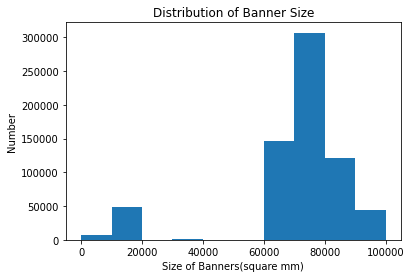

In [52]:
plt.title('Distribution of Banner Size')
plt.xlabel('Size of Banners(square mm)')
plt.ylabel('Number')
plt.hist(adX_train['BannerSize'],range=(0,100000)); 
## The Sizes can be further classified

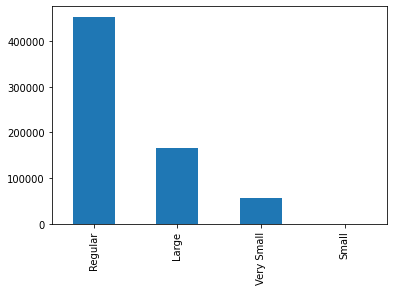

In [57]:
## Classify the Banner to different categories in terms of banner sizes
data = adX_train['BannerSize']
size = [0, 40000, 65000, 80000, 100000]

## If the Banner size is 50000, this is a small size
size_category = ['Very Small', 'Small', 'Regular', 'Large']
adX_train['SizeLabel'] = pd.cut(data, bins=size, labels=size_category)
adX_train['SizeLabel'].value_counts().plot(kind='bar');

In [66]:
## Feature Examination Interaction Time
adX_train['InteractionTime'].describe()

count    750000.000000
mean          0.998686
std           0.998757
min           0.000002
25%           0.288319
50%           0.693069
75%           1.382503
max          13.385281
Name: InteractionTime, dtype: float64

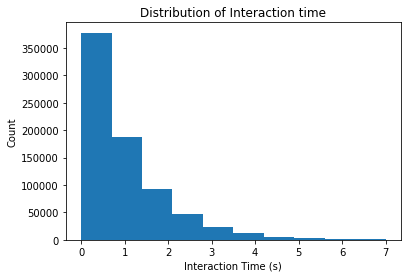

In [65]:
## Feature Examination Interaction Time

plt.title('Distribution of Interaction time')
plt.xlabel('Interaction Time (s)')
plt.ylabel('Count')
plt.hist(adX_train['InteractionTime'],range=(0,7));


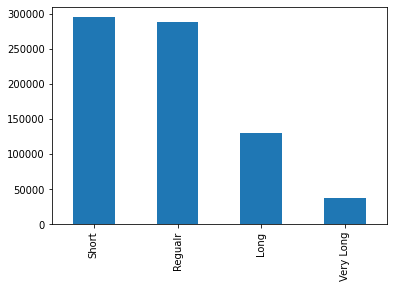

In [69]:
## Feature Engineering Interaction Time
## Classify the Interactin time to different time length categories
data1 = adX_train['InteractionTime']
itime = [0, 0.5, 1.5, 3, 15]

## If the Banner size is 50000, this is a small size
Length_category = ['Short', 'Regualr', 'Long', 'Very Long']
adX_train['InteractionLength'] = pd.cut(data1, bins=itime, labels=Length_category)
adX_train['InteractionLength'].value_counts().plot(kind='bar');

In [58]:
adX_train['Website'].value_counts()

Facebook         449964
Other             73230
Atedra            46235
instagram.com     42025
Craigslist.ca     29729
Yahoo             25331
TubeMogul         21561
Twitter           15858
Amazon            15474
Sympatico          8498
Kijiji             5770
Expedia            5254
Youtube            3854
Weather            3820
Wayfair            2975
AOL                 422
Name: Website, dtype: int64

In [59]:
adX_train['Brand'].value_counts()

Carter's                166875
JoeFresh                143496
Old Navy                113042
Banana Republic          62883
Burberry                 62570
Disney                   62486
gymboree                 52661
Zara                     41736
Gap                      23178
The Children's Place     21073
Name: Brand, dtype: int64

In [ ]:
X_input = adX_train[['Website', 'SizeLabel', 'Brand', 'colour',
       'InteractionTime', 'Daysection', 'Dayofweek']]

y_input = ady_train
y_test = ady_test

In [8]:
## Decide output, split testdata
from sklearn.model_selection import train_test_split
X = Origin.drop(columns=['Action'])
y = Origin['Action']

adX_train, adX_test, ady_train, ady_test = train_test_split(X, y, test_size=0.25)

## Feature engineering from ctrX_train

## fillna
ITmean = adX_train['InteractionTime'].mean() 
adX_train['InteractionTime'] = adX_train['InteractionTime'].fillna(ITmean)
#datetime engineering 
adX_train['ActionTime']=pd.to_datetime(adX_train['ActionTime'].astype('float64')/10**6, unit='s')

hr = pd.to_datetime(adX_train ['ActionTime']).dt.hour
time = [0, 2, 6, 9, 11,19, 24]
time_name = ['late_night', 'early_morning', 'morning', 'noon', 'afternoon', 'evening']
adX_train['Daysection'] = pd.cut(hr, bins=time, labels=time_name)

def wd(a):
    if a==5 or a==6:
        b='weekend'
    else:
        b='weekday'
    return b

adX_train['Dayofweek'] = pd.to_datetime(adX_train ['ActionTime']).dt.dayofweek.apply(wd)

# Banner Size
adX_train['BannerSize'] = adX_train['BannerSize'].str.extract(r'(\d+)x').fillna(0).astype(int) * adX_train['BannerSize'].str.extract(r'x(\d+)').fillna(0).astype(int)
AvgBan = adX_train['BannerSize'].mean()
adX_train['BannerSize'][adX_train['BannerSize'] == 0] = AvgBan

#Threshold Capping BannerSize, InteractionTime
def TCap(columns):
    for i in columns:
        q1, q3 = adX_train[i].quantile([0.25, .75])

        iqr = q3 - q1

        top_boundary = q3 + (iqr * 1.5)

        adX_train.loc[adX_train[i] >= top_boundary,[i]] = top_boundary
TCap_columns=['BannerSize', 'InteractionTime' ]
## TCap(TCap_columns)
     
## arrange inputs and outputs
unusedcolumns = []
X_input = adX_train[['Website', 'BannerSize', 'Brand', 'colour',
       'InteractionTime', 'Daysection', 'Dayofweek']]

y_input = ady_train
y_test = ady_test
     



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
X_input.head()

,Website,BannerSize,Brand,colour,InteractionTime,Daysection,Dayofweek
Unnamed: 0,,,,,,,
454847,instagram.com,88478.473852,Carter's,Blue,1.366059,afternoon,weekday
209390,instagram.com,88478.473852,Disney,other,0.175974,evening,weekday
348206,Facebook,88478.473852,Disney,Gold,0.149630,afternoon,weekday
426062,Facebook,75000.000000,Burberry,Blue,0.646441,afternoon,weekend
859102,Facebook,180000.000000,Carter's,White,0.631212,evening,weekday


In [11]:
X_input['InteractionTime'].describe()

count    750000.000000
mean          0.998344
std           0.996291
min           0.000003
25%           0.288916
50%           0.693692
75%           1.383195
max          13.385281
Name: InteractionTime, dtype: float64

In [ ]:
def FeatureEngineering(X):
    ITmean = X['InteractionTime'].mean() 
    X['InteractionTime'] = X['InteractionTime'].fillna(ITmean)
    #datetime engineering 
    X['ActionTime']=pd.to_datetime(X['ActionTime'].astype('float64')/10**6, unit='s')

    hr = pd.to_datetime(X['ActionTime']).dt.hour
    time = [0, 2, 6, 9, 11,19, 24]
    time_name = ['late_night', 'early_morning', 'morning', 'noon', 'afternoon', 'evening']
    X['Daysection'] = pd.cut(hr, bins=time, labels=time_name)

    def wd(a):
        if a==5 or a==6:
            b='weekend'
        else:
            b='weekday'
        return b

    X['Dayofweek'] = pd.to_datetime(X['ActionTime']).dt.dayofweek.apply(wd)

    # Banner Size
    X['BannerSize'] = X['BannerSize'].str.extract(r'(\d+)x').fillna(0).astype(int) * X['BannerSize'].str.extract(r'x(\d+)').fillna(0).astype(int)
    AvgBan = X['BannerSize'].mean()
    X['BannerSize'][X['BannerSize'] == 0] = AvgBan

    #Threshold Capping BannerSize, InteractionTime
    def TCap(columns):
        for i in columns:
            q1, q3 = X[i].quantile([0.25, .75])

            iqr = q3 - q1

            top_boundary = q3 + (iqr * 1.5)

            X.loc[X[i] >= top_boundary,[i]] = top_boundary
    TCap_columns=['BannerSize', 'InteractionTime' ]
    TCap(TCap_columns)
    X = X[['ID', 'Website', 'BannerSize', 'Brand', 'colour',
       'InteractionTime', 'Daysection', 'Dayofweek']]
    return X

In [ ]:
X_test = FeatureEngineering(adX_test)  


## inputs and test sets
[X_input.shape, X_test.shape, y_input.shape, y_test.shape]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[(750000, 8), (250000, 8), (750000,), (250000,)]

# MACHINE LERNING MODEL DEVELOPMENT

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


estimators = [
    ##('knn', KNeighborsClassifier(n_neighbors=5)),
    ##('dt', DecisionTreeClassifier()),
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ##('xgb', XGBClassifier(max_depth=3,min_child_weight=1.5))
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ros = RandomOverSampler(random_state=42)
##X_resampled_click, y_resampled_click = ros.fit_resample(X_input_click, y_input_click)
from sklearn.decomposition import PCA

## use GridSearch to tune the hyperparameters
pipe = Pipeline([
        ('OHE', OneHotEncoder()),
      ##('Smote',SMOTE()),
        ('o', ros), 
        ##('u', rus),
     ## ('scaling', MaxAbsScaler()),
     ##('scaling', RobustScaler()),
     ('scaling', StandardScaler(with_mean=False)),
    ('simpleimputer', SimpleImputer()),
    ##('DT', DecisionTreeClassifier())
    ##('LR', LogisticRegression())
    ##('PCA', PCA(0.9)),
    ('clf', clf)
    
        
])

parameters = {
    'o__sampling_strategy':[0.8],
    ##'clf__dt__max_depth':  [10, 20],
    ##'clf__knn__n_neighbors': [5, 7],
    'clf__lr__penalty':  ['l2'],
    ##'clf__lr__C':  [20.0, 5.0, 1.0],
    'clf__rf__max_depth':  [10,15],
   ## 'clf__xgb__max_depth':  [3, 5],
    ##'LR__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga' ]
}


gs = GridSearchCV(pipe, parameters, cv=3, scoring='f1', n_jobs=2, verbose=4)

gs.fit(X_input, y_input)
## not enough time to finish running this

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('OHE', OneHotEncoder()),
                                       ('o',
                                        RandomOverSampler(random_state=42)),
                                       ('scaling',
                                        StandardScaler(with_mean=False)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('clf',
                                        StackingClassifier(estimators=[('lr',
                                                                        LogisticRegression()),
                                                                       ('rf',
                                                                        RandomForestClassifier())],
                                                           final_estimator=LogisticRegression()))]),
             n_jobs=2,
             param_grid={'clf__lr__penalty': ['l2'],
                   

In [ ]:
gs.best_params_



In [ ]:
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))